In [1]:
pip install duckdb

Note: you may need to restart the kernel to use updated packages.


# LOADING DATASET

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as ddb
 

# Load data
menu = pd.read_csv('../Data/manu_FC.csv')
orders = pd.read_csv('../Data/selling_transactions.csv')
inventory = pd.read_csv('../Data/inventory_waste.csv')
recipes = pd.read_csv('../Data/recipes.csv')

# Display EDA results
print("Menu DF:")
display(menu.head())
print("Orders DF:")
display(orders.head())
print("Inventory DF:")
display(inventory.head())
print("Recipes DF:")
display(recipes.head())

Menu DF:


,item_id,item_name,category,theoretical_cost,target_margin,is_active
0,ANT-001,Bruschetta al pomodoro,Antipasti,1.8,74,True
1,ANT-002,Caprese,Antipasti,2.5,72,True
2,ANT-003,Prosciutto e melone,Antipasti,3.2,71,True
3,ANT-004,Affettati misti,Antipasti,4.0,69,True
4,PIZ-001,Margherita,Pizze,2.1,77,True


Orders DF:


,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price
0,TXN-000001,2024-01-01 20:22:00,MIL-01,PIZ-002,Glovo,2,16.0
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0
2,TXN-000003,2024-01-01 21:54:00,MIL-01,PRI-003,Deliveroo,2,26.0
3,TXN-000004,2024-01-01 20:51:00,MIL-01,SEC-005,Take-away,2,32.0
4,TXN-000005,2024-01-01 13:02:00,MIL-01,PIZ-007,Deliveroo,1,15.0


Inventory DF:


,date,store_id,item_id,ingredient_name,waste_type,waste_qty,waste_value
0,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Scaduto,0.98,0.78
1,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Sfrido,1.33,1.06
2,2024-01-01,MIL-01,VER-01,Verdure miste (kg),Deteriorato,1.30,4.55
3,2024-01-01,MIL-02,PRO-01,Prosciutto crudo (kg),Errore Comanda,1.92,42.24
4,2024-01-01,MIL-02,VER-01,Verdure miste (kg),Sfrido,1.85,6.48


Recipes DF:


,dish_id,dish_name,ingredient_id,ingredient_name,quantity,unit,costo_unitario,costo_ingrediente
0,ANT-001,Bruschetta al pomodoro,TOM-01,Pomodoro pelato,0.080,kg,1.2,0.10
1,ANT-001,Bruschetta al pomodoro,OLI-01,Olio EVO,0.015,lt,5.0,0.07
2,ANT-001,Bruschetta al pomodoro,BAS-01,Basilico,0.300,mazzo,1.5,0.45
3,ANT-002,Caprese,MOZZ-01,Mozzarella fior di latte,0.125,kg,5.5,0.69
4,ANT-002,Caprese,TOM-01,Pomodoro pelato,0.150,kg,1.2,0.18


### **Dfs are quite balanced in some features, so I decided augmenting data for better analysis**

### DATA AUGMENTATION

In [3]:
def inject_realism_full(sales_df, inventory_df, menu_df):
    print("--- REALISTIC SIMULATION: FULL MENU ---")
    
    # Work on copies to avoid modifying original data
    sales_df = sales_df.copy()
    inventory_df = inventory_df.copy()
    
    # --- 1. SETTING SCENARIO ---
    sales_scenario = {
        'Acqua naturale':       {'qty': 4.0, 'price': 1.0},
        'Caffè':                {'qty': 3.5, 'price': 1.0},
        'Spritz':               {'qty': 2.0, 'price': 1.2},
        'Vino rosso (calice)':  {'qty': 1.5, 'price': 1.1},
        'Birra media':          {'qty': 2.5, 'price': 1.0},
        'Margherita':           {'qty': 3.0, 'price': 1.0},
        'Diavola':              {'qty': 0.6, 'price': 1.0},
        'Marinara':             {'qty': 0.2, 'price': 1.0},
        'Pizza gourmet tartufo':{'qty': 0.4, 'price': 1.5},
        'Bufala e pachino':     {'qty': 1.2, 'price': 1.2},
        'Carbonara':            {'qty': 2.2, 'price': 1.0},
        'Amatriciana':          {'qty': 1.8, 'price': 1.0},
        'Cacio e pepe':         {'qty': 1.5, 'price': 1.1},
        'Branzino al forno':    {'qty': 0.8, 'price': 1.3},
        'Tagliata di manzo':    {'qty': 0.7, 'price': 1.4},
        'Cotoletta alla milanese': {'qty': 1.5, 'price': 1.1},
        'Tiramisù':             {'qty': 2.0, 'price': 1.0},
        'Panna cotta':          {'qty': 0.5, 'price': 1.0},
    }

    waste_scenario = {
        'Mozzarella (kg)':          3.5,
        'Pesce branzino (kg)':      4.0,
        'Verdure miste (kg)':       2.5,
        'Prosciutto crudo (kg)':    1.5,
        'Carne manzo (kg)':         1.2,
        'Salame piccante (kg)':     1.8,
        'Funghi porcini (kg)':      1.3,
        'Farina tipo 00 (kg)':      0.2,
        'Olio EVO (lt)':            0.1,
        'Pomodoro San Marzano (kg)':0.3,
    }

    # --- 2. APPLYING SALES LOGIC ---
    sales_df['unit_price_temp'] = sales_df['total_net_price'] / sales_df['qty']
    
    for item_name, multipliers in sales_scenario.items():
        try:
            target_ids = menu_df.loc[menu_df['item_name'] == item_name, 'item_id'].values
            if len(target_ids) > 0:
                t_id = target_ids[0]
                mask = sales_df['item_id'] == t_id
                
                if mask.any():
                    sales_df.loc[mask, 'qty'] *= multipliers['qty']
                    new_price = sales_df.loc[mask, 'unit_price_temp'] * multipliers['price']
                    sales_df.loc[mask, 'total_net_price'] = sales_df.loc[mask, 'qty'] * new_price
        except Exception as e:
            print(f"Skipping {item_name}: {e}")

    sales_df.drop(columns=['unit_price_temp'], inplace=True)

    # --- 3. APPLYING WASTE LOGIC ---
    # Adding random noise to waste quantities
    inventory_df['waste_qty'] *= 1.0 
    
    # setting known multipliers for specific ingredients
    known_mapping = {
        'MOZZ-01': 3.5, # Mozzarella
        'PES-01':  4.0, # Branzino
        'FAR-01':  0.2, # Farina
        'SAL-01':  1.8, # Salame
        'OLI-01':  0.1, # Olio
        'TOM-01':  0.3, # Pomodoro
        'FUN-01':  1.3  # Funghi
    }
    
    for ing_id, mult in known_mapping.items():
        col_name = 'ingredient_id' if 'ingredient_id' in inventory_df.columns else 'item_id'
        mask = inventory_df[col_name] == ing_id
        
        if mask.any():
            inventory_df.loc[mask, 'waste_qty'] *= mult
            inventory_df.loc[mask, 'waste_value'] *= mult

    print("Data correctly unbalanced!")
    
    return sales_df, inventory_df

orders, inventory = inject_realism_full(orders, inventory, menu)

--- REALISTIC SIMULATION: FULL MENU ---
Data correctly unbalanced!


/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_70617/2540362906.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.  7.  7.  ... 7.  7.  3.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_df.loc[mask, 'qty'] *= multipliers['qty']


# REVPASH

Analisi RevPASH avviata su 50 posti a sedere.


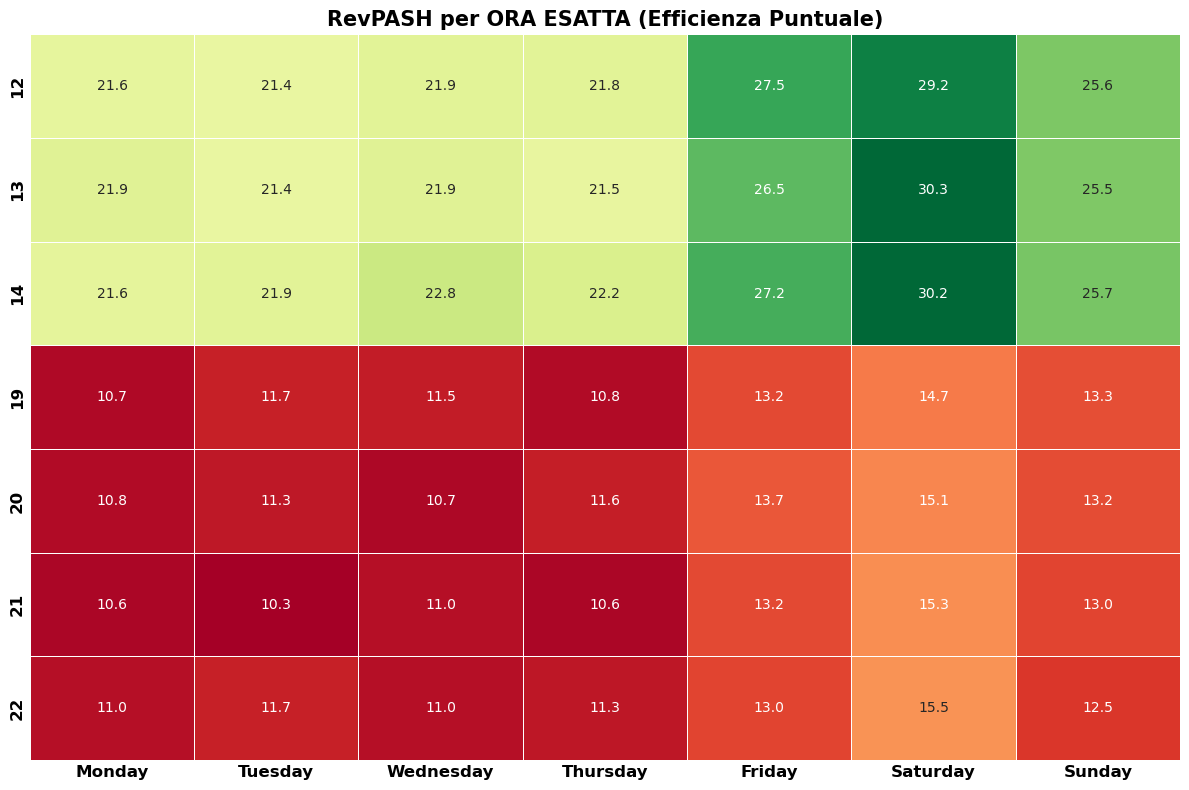

In [4]:
# 1. -- MANAGERIAL CONFIGURATION --
# Setting 50 seats as a fixed capacity for the restaurant, which will be used in the RevPASH calculation. 
# This allows us to simulate a realistic scenario where the restaurant has a certain number of tables and seats available
SEATS = 50  

# Defining the order of days for the graphs
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Defining the order of time slots for better visualization in the heatmap
slots_order = ['Lunch 1', 'Lunch 2', 'Dinner 1', 'Dinner 2', 'Night']

# 2. -- DATAS PREPARATION --
# working on a copy to avoid modifying original data
df_revpash = orders.copy() # working on a copy to avoid modifying original data

# Convert 'timestamp' to datetime and extract date, weekday, and hour for analysis
df_revpash['timestamp'] = pd.to_datetime(df_revpash['timestamp'])
df_revpash['date'] = df_revpash['timestamp'].dt.date
df_revpash['weekday'] = df_revpash['timestamp'].dt.day_name()
df_revpash['hour'] = df_revpash['timestamp'].dt.hour

# Considering only dine-in transactions for a more accurate RevPASH analysis
df_revpash = df_revpash[df_revpash['channel'] == 'Sala']

print(f"Analisi RevPASH avviata su {SEATS} posti a sedere.")

# -- 3. CALCULATION AND VISUALIZATION --
# Calculating: total Revenue and number of unique days for that Day/Time combination
hourly_stats = df_revpash.groupby(['weekday', 'hour']).agg({
    'total_net_price': 'sum',
    'date': 'nunique'}).reset_index()

# Operational Filter: list only the likely hours (e.g. 11:00 - 24:00) to clean the graph
hourly_stats = hourly_stats[hourly_stats['hour'].between(11, 23)]

# RevPASH calculation
hourly_stats['available_seat_hours'] = hourly_stats['date'] * SEATS
hourly_stats['RevPASH'] = hourly_stats['total_net_price'] / hourly_stats['available_seat_hours']

# -- 4. PIVOTING AND PLOTTING --
# Pivoting the data to have hours as rows and weekdays as columns for the heatmap
pivot_hourly = hourly_stats.pivot(index='hour', columns='weekday', values='RevPASH')
pivot_hourly = pivot_hourly.reindex(columns=days_order) 

# Visualizzationm
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_hourly, cmap='RdYlGn', annot=True, fmt='.1f', linewidths=.5, cbar=False)
plt.title('RevPASH per ORA ESATTA (Efficienza Puntuale)', fontsize=15, weight='bold')
plt.xlabel('')
plt.tick_params(axis='both', which='both', length=0) 
plt.xticks(fontsize=12, weight='bold')
plt.ylabel('')
plt.yticks(fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


# TABLE TURNOVER

### DATA AUGMENTATION - TABLE TURNOVER

In [18]:
# Working on a copy so as not to mess with the original
df_tableturnover = df_revpash.copy()

# Questa funzione traduce un'ora numerica (es. 13) in un concetto di business (es. Lunch 2)
def assign_time_slot(h):
    if h == 11: return 'Morning'         # 11:00 - 11:59
    elif h == 12: return 'Lunch 1'       # 12:00 - 12:59
    elif h in [13, 14]: return 'Lunch 2' # 13:00 - 14:59
    elif h == 19: return 'Dinner 1'      # 19:00 - 19:59
    elif h in [20, 21]: return 'Dinner 2'# 20:00 - 21:59
    elif h >= 22: return 'Night'         # 22:00 in poi
    else: return 'Other'                 # Orari non operativi

# Applichiamo la logica riga per riga
df_tableturnover['time_slot'] = df_tableturnover['hour'].apply(assign_time_slot)

# -- 1. WAITER SIMULATION --
# Creating 4 typical profiles
staff_list = ['Marco (Senior)', 'Sofia (Sommelier)', 'Luca (Junior)', 'Giulia (Part-time)']

# Odds: Senior waiters serve more tables than Junior ones
staff_probs = [0.35, 0.25, 0.25, 0.15]

# Assigning a waiter for each ORDER_ID (the whole table served by the same waiter)
unique_orders = df_tableturnover['transaction_id'].unique()
assigned_staff = np.random.choice(staff_list, size=len(unique_orders), p=staff_probs)

# ORDER_ID -> Waiter mapping
order_staff_map = dict(zip(unique_orders, assigned_staff))
df_tableturnover['waiter'] = df_tableturnover['transaction_id'].map(order_staff_map)


# --- 2. TABLE TURNOVER SIMULATION ---
# Duration depends on WHEN you eat (At lunch you rush, at dinner you chat)
def simulate_duration(row):
    # Set base: 45 minutes
    duration = 45 
    # Random noise (+/- 15 min)
    duration += np.random.randint(-10, 20)
    
    # If it's Dinner (Dinner 1/2), you stay longer (+30 min)
    if 'Dinner' in row['time_slot']:
        duration += 30 + np.random.randint(0, 30)
    # If it's Weekend, you stay longer (+15 min)\
    if row['weekday'] in ['Friday', 'Saturday', 'Sunday']:
        duration += 15
        
    return duration


# Calculating the simulated duration for each row (in minutes)
df_tableturnover['table_duration_min'] = df_tableturnover.apply(lambda row: simulate_duration(row), axis=1)

print("Dataset boosted!")
display(df_tableturnover[['timestamp', 'time_slot', 'waiter', 'total_net_price', 'table_duration_min']])

Dataset boosted!


,timestamp,time_slot,waiter,total_net_price,table_duration_min
1,2024-01-01 13:52:00,Lunch 2,Luca (Junior),10.50,61
5,2024-01-01 12:19:00,Lunch 1,Marco (Senior),54.00,55
7,2024-01-01 12:25:00,Lunch 1,Sofia (Sommelier),21.45,64
8,2024-01-01 20:46:00,Dinner 2,Giulia (Part-time),20.00,86
9,2024-01-01 13:53:00,Lunch 2,Sofia (Sommelier),16.00,41
...,...,...,...,...,...
159911,2024-12-31 21:37:00,Dinner 2,Marco (Senior),21.45,101
159912,2024-12-31 14:21:00,Lunch 2,Giulia (Part-time),42.90,41
159913,2024-12-31 22:57:00,Night,Luca (Junior),14.00,46
159914,2024-12-31 22:08:00,Night,Marco (Senior),16.00,51


### WAITER PERSONAL PERFORMANCE

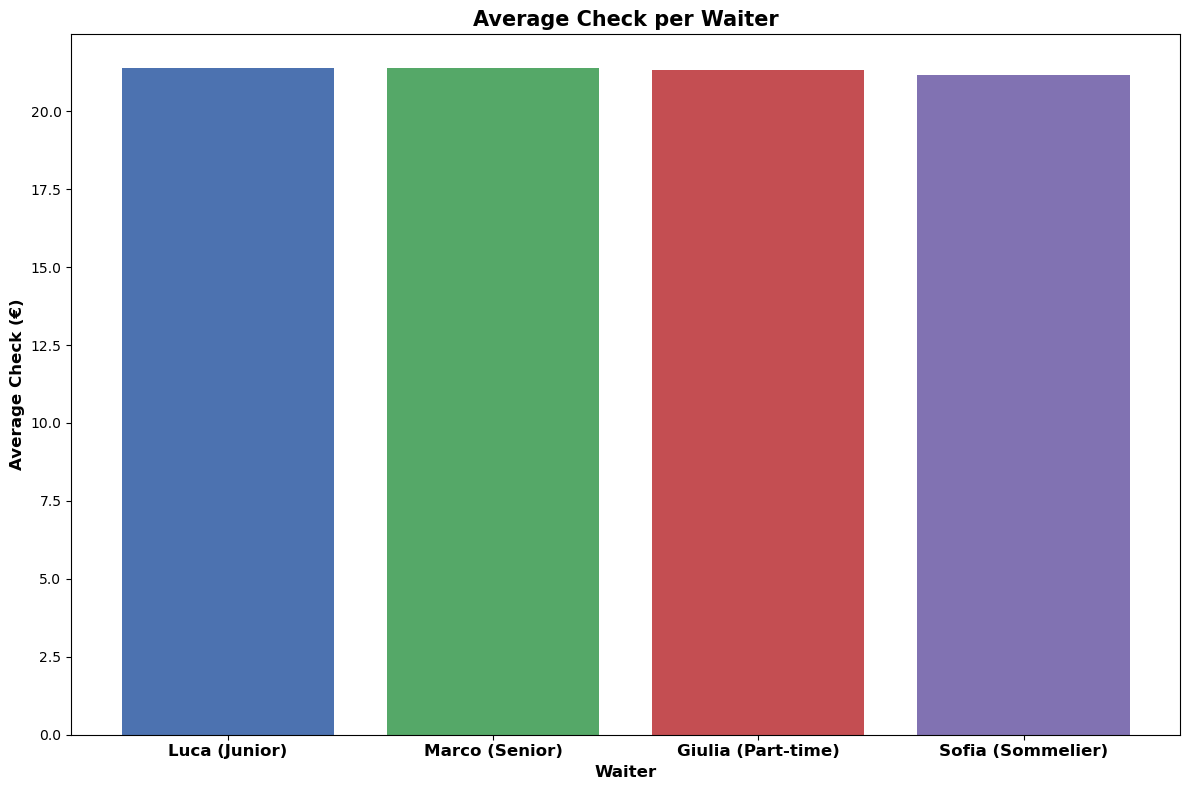

In [22]:
# checking the average check per waiter to see who sell more
avg_check_waiter = df_tableturnover.groupby('waiter')['total_net_price'].mean().reset_index()
avg_check_waiter = avg_check_waiter.sort_values(by='total_net_price', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(avg_check_waiter['waiter'], avg_check_waiter['total_net_price'], color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
plt.title('Average Check per Waiter', fontsize=15, weight='bold')
plt.xlabel('Waiter', fontsize=12, weight='bold')
plt.ylabel('Average Check (€)', fontsize=12, weight='bold')
plt.xticks(fontsize=12, weight='bold')      
plt.tight_layout()
plt.show()    

### AVERAGE DURATION PER TIMESLOT

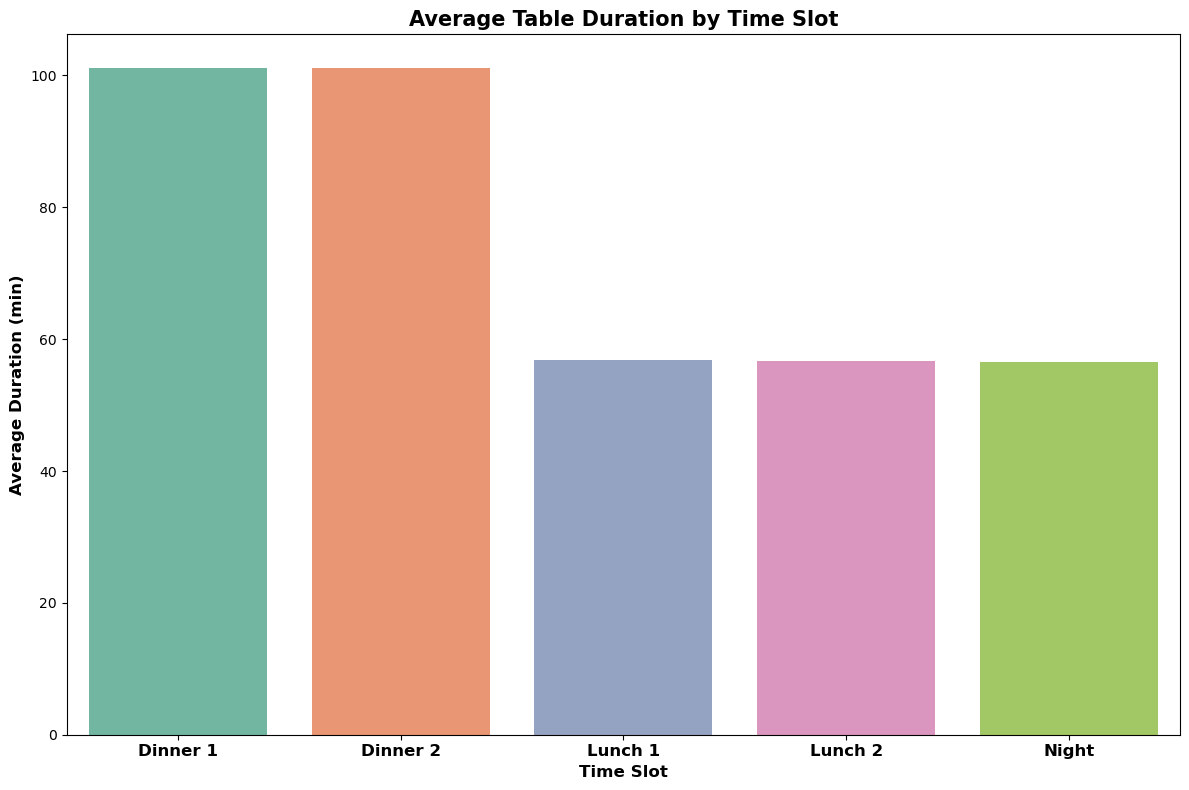

In [24]:
# checking avg duration per time slot
avg_duration_slot = df_tableturnover.groupby('time_slot')['table_duration_min'].mean().reset_index()    
plt.figure(figsize=(12, 8))
sns.barplot(x='time_slot', y='table_duration_min', data=avg_duration_slot, hue='time_slot', palette='Set2', dodge=False)
plt.title('Average Table Duration by Time Slot', fontsize=15, weight='bold')
plt.xlabel('Time Slot', fontsize=12, weight='bold')         
plt.ylabel('Average Duration (min)', fontsize=12, weight='bold')
plt.xticks(fontsize=12, weight='bold')
plt.tight_layout()
plt.show()